In [1]:
import math
import os
import datetime

import numpy as np
import tifffile
import skimage
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
today = datetime.datetime.today()
date_str = f'{today.year}-{today.month}-{today.day}-{today.minute}-{today.microsecond}'
date_str

'2024-1-20-41-688896'

In [4]:
name = 'faces'
directory = f'../data/{name}'
output_fp = f'../data/practice/todo/{name}_{date_str}.png'

In [5]:
if name in ['spines']:
    fp = '/Users/erikstorrs/Downloads/Academic Bundle Reference Pictures (Female 360) (small)/female-360-34.jpg'
else:
    fps = [os.path.join(directory, root) for root in os.listdir(directory)]
    fp = np.random.choice(fps)
    # fp = '../data/faces/th (48).jpeg'
    root = fp.split('/')[-1].split('.')[0]
    print(fp)

../data/faces/Copy of Untitled-4.jpg


In [6]:
## https://stackoverflow.com/questions/28260962/calculating-angles-between-line-segments-python-with-math-atan2
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360
    
    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 
        
        return ang_deg

In [7]:
def on_pick(event, mag=25):
    global PT1
    global REF_DIST
    global REF_LINE
#     print(REF_LINE)
    is_first = PT1 is None
    
    x, y = event.xdata, event.ydata
    
    if is_first:
        PT1 = np.asarray([x, y])
        for k, ax in axd.items():
            if k not in ['D']:
                for art in ax.lines: art.remove()
                for art in ax.patches: art.remove()
                for art in ax.texts: art.remove()
                for art in ax.collections: art.remove()

        axd['A'].imshow(img)
        axd['A'].scatter(x, y, s=2, color='red')
    else:
        axd['A'].scatter(x, y, s=1, color='red')
        pt2 = np.asarray([event.xdata, event.ydata])
        axd['A'].add_line(mlines.Line2D([PT1[0], pt2[0]], [PT1[1], pt2[1]], color='red'))
        axd['C'].add_line(mlines.Line2D([PT1[0], pt2[0]], [PT1[1], pt2[1]], color='red'))
        axd['B'].add_line(mlines.Line2D([PT1[0], pt2[0]], [PT1[1], pt2[1]], color='red'))
        axd['D'].add_line(mlines.Line2D([PT1[0], pt2[0]], [PT1[1], pt2[1]], color='red', linewidth=.5))
        
        if REF_DIST is None: # first pass and ref is not set yet
            REF_DIST = np.linalg.norm(PT1 - pt2)
            REF_LINE = [PT1.copy(), pt2.copy()]

        up = np.asarray([0, 1])
        down = np.asarray([0, -1])
        right = np.asarray([1, 0])
        left = np.asarray([-1, 0])

        for ax in axd.values():
            rect = patches.Rectangle(
                (min(PT1[0], pt2[0]), min(PT1[1], pt2[1])), abs(PT1[0] - pt2[0]), abs(PT1[1] - pt2[1]),
                linewidth=1, edgecolor='r', facecolor='none')
            axd['C'].add_patch(rect)

            vert = down if PT1[1] > pt2[1] else up
            horz = left if PT1[0] > pt2[0] else right

            base = 20
            if PT1[0] > pt2[0] and PT1[1] > pt2[1]:
                pt1_vert_offset = np.asarray([0, mag])
                pt1_horz_offset = np.asarray([mag, 0])
            elif PT1[0] > pt2[0] and PT1[1] <= pt2[1]:
                pt1_vert_offset = np.asarray([0, -mag])
                pt1_horz_offset = np.asarray([mag, 0])
            elif PT1[0] <= pt2[0] and PT1[1] > pt2[1]:
                pt1_vert_offset = np.asarray([0, mag])
                pt1_horz_offset = np.asarray([-mag, 0])
            else:
                pt1_vert_offset = np.asarray([0, -mag])
                pt1_horz_offset = np.asarray([-mag, 0])

            coords = PT1 + pt1_horz_offset
            axd['C'].text(coords[0], coords[1], str(int(ang([PT1, pt2], [PT1, PT1 + vert]))))
            coords = PT1 + pt1_vert_offset
            axd['C'].text(coords[0], coords[1], str(int(ang([PT1, pt2], [PT1, PT1 + horz]))))

            coords = pt2 - pt1_horz_offset
            axd['C'].text(coords[0], coords[1], str(int(ang([PT1, pt2], [pt2, pt2 + vert]))))
            coords = pt2 - pt1_vert_offset
            axd['C'].text(coords[0], coords[1], str(int(ang([PT1, pt2], [pt2, pt2 + horz]))))
            
            dist = np.linalg.norm(PT1 - pt2)
            ratio = dist / REF_DIST
            axd['B'].text(0, 50, "{:.2f}".format(ratio))
            axd['B'].add_line(mlines.Line2D([REF_LINE[0][0], REF_LINE[1][0]], [REF_LINE[0][1], REF_LINE[1][1]],
                                            color='blue'))
            
            dist = np.linalg.norm(PT1 - pt2)
            ratio = dist / REF_DIST
            a1, a2 = (
                int(ang([PT1, pt2], [PT1, PT1 + vert])),
                int(ang([PT1, pt2], [PT1, PT1 + horz]))
            )
            angle = min(a1, a2)
            coords = (PT1[0] + pt2[0]) / 2, (PT1[1] + pt2[1]) / 2
            axd['D'].text(coords[0], coords[1], str(angle) + ' ' + "{:.2f}".format(ratio), fontsize=1, color='blue')
#             axd['D'].add_line(mlines.Line2D([REF_LINE[0][0], REF_LINE[1][0]], [REF_LINE[0][1], REF_LINE[1][1]],
#                                             color='blue'))


    if not is_first:
        PT1 = None

    for ax in axd.values(): ax.axis('off')
    fig.canvas.draw()

In [8]:
# class Event():
#     def __init__(self, x, y):
#         self.xdata = x
#         self.ydata = y
# e1 = Event(50, 100)
# on_pick(e1)

<IPython.core.display.Javascript object>


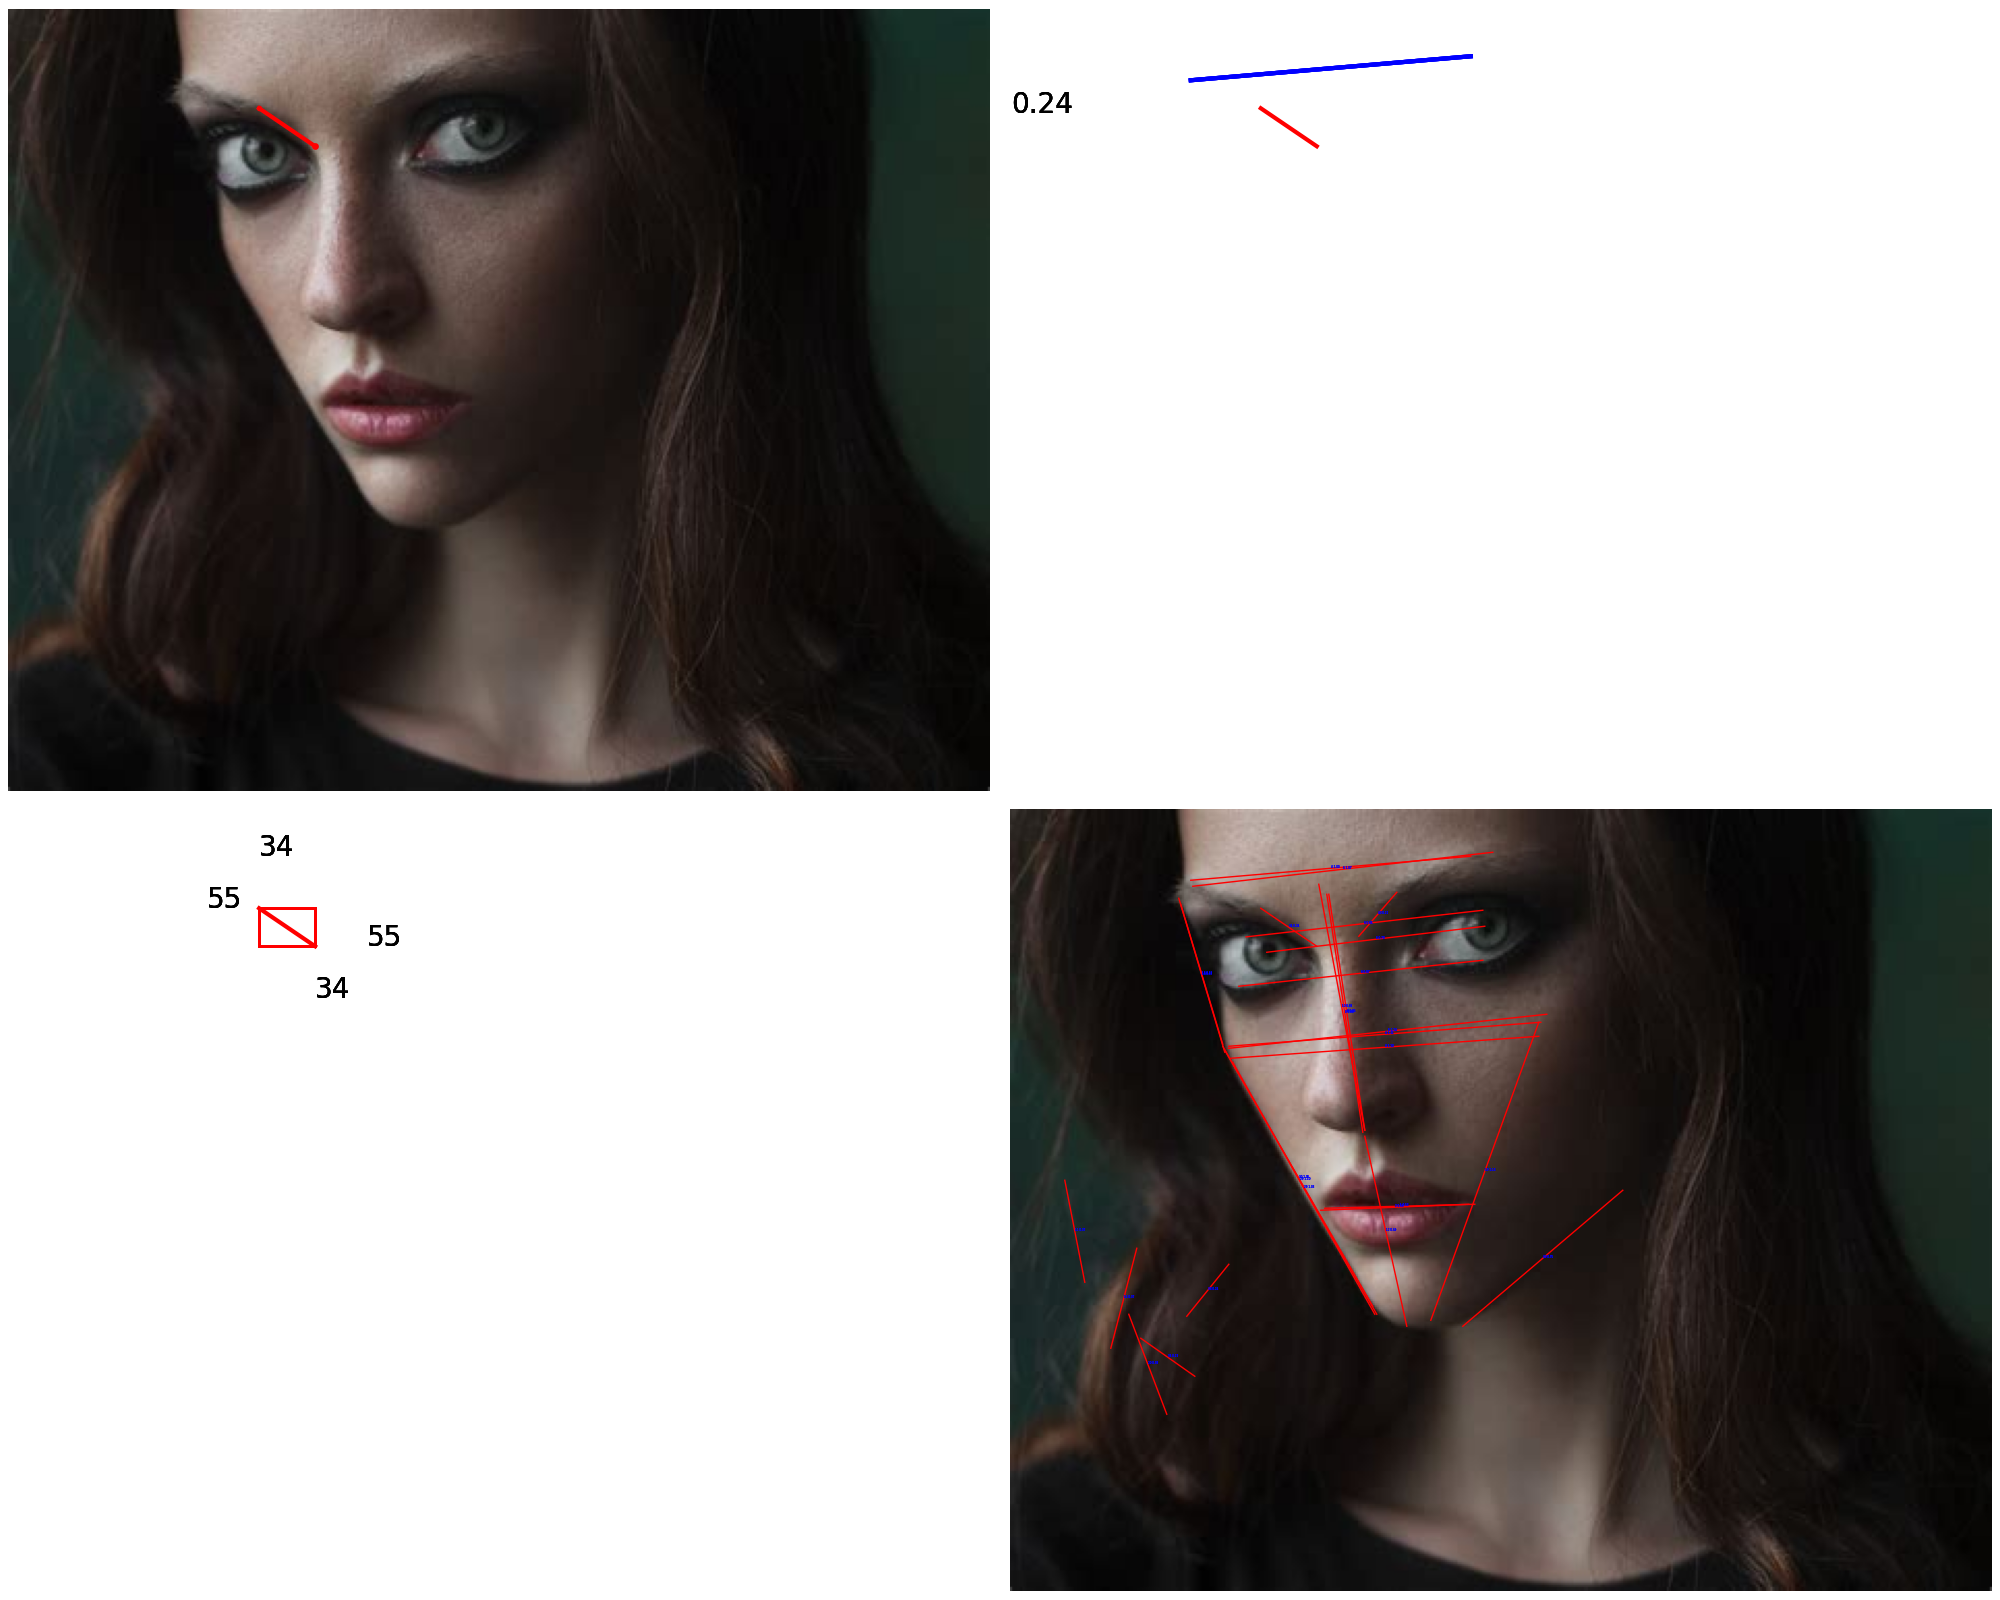

In [9]:
figsize = (10, 8)
fp = np.random.choice(fps)
img = skimage.io.imread(fp)
# img = np.full((256, 256, 3), 255, dtype=np.uint8)
blank = np.full_like(img, 255)
REF_DIST = None
REF_LINE = None
PT1 = None

layout = """
AB
CD
"""
fig = plt.figure(layout="constrained", figsize=figsize)
axd = fig.subplot_mosaic(layout)
axd['A'].imshow(img)
axd['B'].imshow(blank)
axd['C'].imshow(blank)
axd['D'].imshow(img)

for ax in axd.values(): ax.axis('off')

fig.canvas.mpl_connect('button_press_event', on_pick)
plt.show()



In [12]:
def show_piece(ax, figsize):
    fig2 = plt.figure(figsize=figsize)
    ax.figure=fig2
    fig2.axes.append(ax)
    fig2.add_axes(ax)

    dummy = fig2.add_subplot(111)
    ax.set_position(dummy.get_position())
    dummy.remove()

In [13]:
ax=axd['D']
show_piece(ax, figsize)
plt.savefig(output_fp, dpi=600)

<IPython.core.display.Javascript object>

In [23]:
import shutil
ext = output_fp.split('.')[-1]
shutil.copy(fp, output_fp.replace(f'.{ext}', f'_ref.{ext}'))

'../data/practice/todo/faces_2024-1-11-40-318777_ref.png'